In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import itertools
import warnings
from joblib import Parallel, delayed
from itertools import product

warnings.filterwarnings('ignore')

# Carica i file CSV
ristoranti = pd.read_csv('ristoranti.csv', sep=';', parse_dates=['data'])
meteo1 = pd.read_csv('meteo1.csv', parse_dates=['data'])
meteo2 = pd.read_csv('meteo2.csv', parse_dates=['data'])
meteo3 = pd.read_csv('meteo3.csv', parse_dates=['data'])
meteo4 = pd.read_csv('meteo4.csv', parse_dates=['data'])
serieA = pd.read_csv('SerieA.csv', parse_dates=['data'])

# Pivot della tabella ristoranti
ristoranti_pivot = ristoranti.pivot_table(index='data', columns='ristorante', values='lordototale', fill_value=0).reset_index()

# Creazione del dizionario per abbinare i dataframe dei ristoranti ai dataframe meteo corrispondenti
meteo_dict = {'R000': meteo1, 'R001': meteo2, 'R002': meteo2, 'R003': meteo2, 'R004': meteo3, 'R005': meteo4}

# Separazione in 6 dataframe diversi e unione con le colonne meteo corrispondenti e con il dataframe SerieA
for i in range(6):
    ristorante = f'R{i:03d}'
    df = ristoranti_pivot[['data', ristorante]]
    df = pd.merge(df, meteo_dict[ristorante], on='data', how='outer')
    df = pd.merge(df, serieA, on='data', how='outer')
    # Mantieni solo le righe in cui tutte le serie storiche hanno valori validi
    df.dropna(thresh=4, inplace=True)
    # Ricampionamento a livello mensile
    df.set_index('data', inplace=True)
    df = df.resample('M').agg({'partite giornaliere': 'sum', 'precipitazioni(mm)': 'sum', ristorante: 'sum', 'temperatura(°C)': 'mean'})
    
    # Rimuovi le righe con valore 0 dall'inizio
    while df.iloc[0][ristorante] == 0:
        df = df.iloc[1:]
    
    # Rimuovi le righe con valore 0 dalla fine
    while df.iloc[-1][ristorante] == 0:
        df = df.iloc[:-1]
    df=df.iloc[:-1]
    globals()[f'ristorante_{ristorante}_mensile'] = df

# Definisci i range di valori per i parametri del modello Prophet
changepoint_prior_scale_values = [x/10 for x in range(201)]
seasonality_prior_scale_values = [0,0.01, 0.1, 1, 10]
holidays_prior_scale_values = [0, 0.001, 0.01,  1, 10]
seasonality_mode_values = ['additive', 'multiplicative']
hyperparameters_prophet = list(product(changepoint_prior_scale_values, seasonality_prior_scale_values, holidays_prior_scale_values, seasonality_mode_values))

# Definisci i range di valori per i parametri del modello SARIMAX
p_range = range(8)
d_range = range(6)
q_range = range(8)
P_range = range(3)
D_range = range(2)
Q_range = range(3)

# Crea una lista di tutte le combinazioni di iperparametri per SARIMAX
hyperparameters_sarimax = list(itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range))

#Crea la pipeline di SARIMAX
def sarimax_pipeline(df):
    # Dividi il dataframe in train e test
    train_size = int(len(df) * 0.8)
    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]
# Definisci una funzione per addestrare un modello SARIMAX con una data combinazione di iperparametri e calcolare l'RMSE normalizzato sul test set
    def evaluate_sarimax_model(hyperparameters):
        try:
            p, d, q, P, D, Q = hyperparameters
            exog_train = train_df[['partite giornaliere', 'precipitazioni(mm)', 'temperatura(°C)']]
            exog_test = test_df[['partite giornaliere', 'precipitazioni(mm)', 'temperatura(°C)']]
            model = SARIMAX(train_df[ristorante], exog=exog_train, order=(p,d,q), seasonal_order=(P,D,Q,12)).fit()
            prediction = model.predict(start=test_df.index[0], end=test_df.index[-1], exog=exog_test)
            rmse = np.sqrt(mean_squared_error(test_df[ristorante], prediction))
            nrmse = rmse / (test_df[ristorante].max() - test_df[ristorante].min())
        except:
            nrmse = np.inf
        return nrmse
    
    # Esegui la funzione evaluate_sarimax_model in parallelo su tutte le combinazioni di iperparametri
    nrmse_sarimax = Parallel(n_jobs=-1)(delayed(evaluate_sarimax_model)(hyperparameters) for hyperparameters in hyperparameters_sarimax)
    
    # Trova la combinazione di iperparametri che minimizza l'RMSE normalizzato
    best_index_sarimax = np.argmin(nrmse_sarimax)
    best_hyperparameters_sarimax = hyperparameters_sarimax[best_index_sarimax]
    p, d, q, P, D, Q = best_hyperparameters_sarimax
    
    # Addestra il modello SARIMAX sul train set utilizzando la migliore combinazione di iperparametri
    exog_train = train_df[['partite giornaliere', 'precipitazioni(mm)', 'temperatura(°C)']]
    model_sarimax = SARIMAX(train_df[ristorante], exog=exog_train, order=(p,d,q), seasonal_order=(P,D,Q,12)).fit()
    
    # Stampa gli iperparametri usati dal modello SARIMAX e l'RMSE normalizzato
    print(f'SARIMAX{model_sarimax.specification.order}x{model_sarimax.specification.seasonal_order} - RMSE normalizzato: {nrmse_sarimax[best_index_sarimax]}')
    
    # Esegui una predizione sul test set utilizzando il modello SARIMAX addestrato
    exog_test = test_df[['partite giornaliere', 'precipitazioni(mm)', 'temperatura(°C)']]
    prediction_sarimax = model_sarimax.predict(start=test_df.index[0], end=test_df.index[-1], exog=exog_test)
    
    # Calcola i residui per SARIMAX
    residuals_sarimax = test_df[ristorante] - prediction_sarimax
    
    # Stampa il grafico con train, test e prediction per SARIMAX
    fig, ax = plt.subplots()
    ax.plot(train_df.index, train_df[ristorante]/1000.0, label='train')
    ax.plot(test_df.index, test_df[ristorante]/1000.0, label='test')
    ax.plot(test_df.index, prediction_sarimax/1000.0, label='prediction')
    ax.legend()
    fig.autofmt_xdate()
    # Aggiungi le legende degli assi
    ax.set_xlabel('Data')
    ax.set_ylabel('Migliaia di euro')
    plt.show()
    
    # Stampa il grafico con i residui per SARIMAX
    fig, ax = plt.subplots()
    ax.plot(test_df.index, residuals_sarimax/1000.0, label='residuals')
    ax.legend()
    fig.autofmt_xdate()
    # Aggiungi le legende degli assi
    ax.set_xlabel('Data')
    ax.set_ylabel('Migliaia di euro')
    plt.show()

    return p,d,q,P,D,Q

#Crea la pipeline di Prophet
def prophet_pipeline(df):
    print('Inizio della funzione prophet_pipeline')
    
    # Prepara i dati per Prophet
    df = df.reset_index().rename(columns={'data': 'ds', ristorante: 'y'})
    
    # Dividi il dataframe in train e test
    train_size = int(len(df) * 0.8)
    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]
 # Definisci una funzione per addestrare un modello Prophet con una data combinazione di iperparametri e calcolare l'RMSE normalizzato sul test set
    def evaluate_prophet_model(hyperparameters):
        try:
            changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale, seasonality_mode = hyperparameters
            model = Prophet(changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale, holidays_prior_scale=holidays_prior_scale, seasonality_mode=seasonality_mode)
            model.add_regressor('partite giornaliere')
            model.add_regressor('precipitazioni(mm)')
            model.add_regressor('temperatura(°C)')
            model.fit(train_df)
            future = model.make_future_dataframe(periods=len(test_df), freq='MS')
            future['partite giornaliere'] = df['partite giornaliere']
            future['precipitazioni(mm)'] = df['precipitazioni(mm)']
            future['temperatura(°C)'] = df['temperatura(°C)']
            forecast = model.predict(future)
            prediction = forecast.iloc[-len(test_df):]['yhat']
            rmse = np.sqrt(mean_squared_error(test_df['y'], prediction))
            nrmse = rmse / (test_df['y'].max() - test_df['y'].min())
        except Exception as e:
            print(f'Errore durante la valutazione del modello Prophet: {e}')
            nrmse = np.inf
        return nrmse
    
    print('Esecuzione della funzione evaluate_prophet_model in parallelo su tutte le combinazioni di iperparametri')
    nrmse_prophet = Parallel(n_jobs=-1)(delayed(evaluate_prophet_model)(hyperparameters) for hyperparameters in hyperparameters_prophet)
    
    print('Ricerca della combinazione di iperparametri che minimizza l\'RMSE normalizzato')
    best_index_prophet = np.argmin(nrmse_prophet)
    best_hyperparameters_prophet = hyperparameters_prophet[best_index_prophet]
    changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale, seasonality_mode = best_hyperparameters_prophet
    
    print('Addestramento del modello Prophet sul train set utilizzando la migliore combinazione di iperparametri')
    model_prophet = Prophet(changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale, holidays_prior_scale=holidays_prior_scale, seasonality_mode=seasonality_mode)
    model_prophet.add_regressor('partite giornaliere')
    model_prophet.add_regressor('precipitazioni(mm)')
    model_prophet.add_regressor('temperatura(°C)')
    model_prophet.fit(train_df)
    
    # Stampa gli iperparametri usati dal modello Prophet e l'RMSE normalizzato
    print(f'Prophet(changepoint_prior_scale={changepoint_prior_scale}, seasonality_prior_scale={seasonality_prior_scale}, holidays_prior_scale={holidays_prior_scale}, seasonality_mode={seasonality_mode}) - RMSE normalizzato: {nrmse_prophet[best_index_prophet]}')
    
    # Esegui una predizione sul test set utilizzando il modello Prophet addestrato
    future = model_prophet.make_future_dataframe(periods=len(test_df), freq='MS')
    future['partite giornaliere'] = df['partite giornaliere']
    future['precipitazioni(mm)'] = df['precipitazioni(mm)']
    future['temperatura(°C)'] = df['temperatura(°C)']
    forecast = model_prophet.predict(future)
    prediction_prophet = forecast.iloc[-len(test_df):]['yhat']
    
    # Calcola i residui per Prophet
    residuals_prophet = test_df['y'] - prediction_prophet
    
    # Stampa il grafico con train, test e prediction per Prophet
    fig, ax = plt.subplots()
    ax.plot(train_df['ds'], train_df['y']/1000.0, label='train')
    ax.plot(test_df['ds'], test_df['y']/1000.0, label='test')
    ax.plot(test_df['ds'], prediction_prophet/1000.0, label='prediction')
    ax.legend()
    fig.autofmt_xdate()
     # Aggiungi le legende degli assi
    ax.set_xlabel('Data')
    ax.set_ylabel('Migliaia di euro')
    plt.show()
    # Stampa il grafico con i residui per Prophet
    fig, ax = plt.subplots()
    ax.plot(test_df['ds'], residuals_prophet/1000.0, label='residuals')
    ax.legend()
    fig.autofmt_xdate()
    # Aggiungi le legende degli assi
    ax.set_xlabel('Data')
    ax.set_ylabel('Migliaia di euro')
    plt.show()
    
    print('Fine della funzione prophet_pipeline')
    return changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale, seasonality_mode

Esecuzione della pipeline SARIMAX per R000
SARIMAX(2, 5, 6)x(1, 1, 2, 12) - RMSE normalizzato: 0.15871301232809648


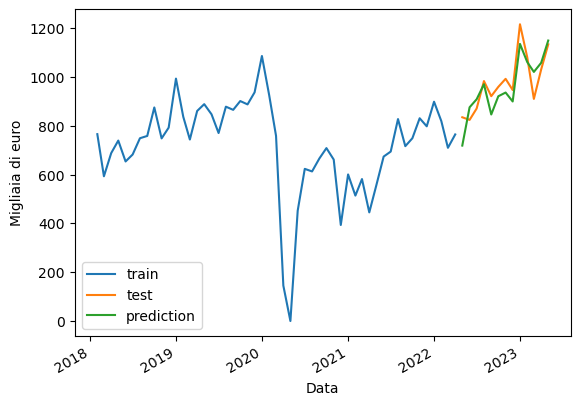

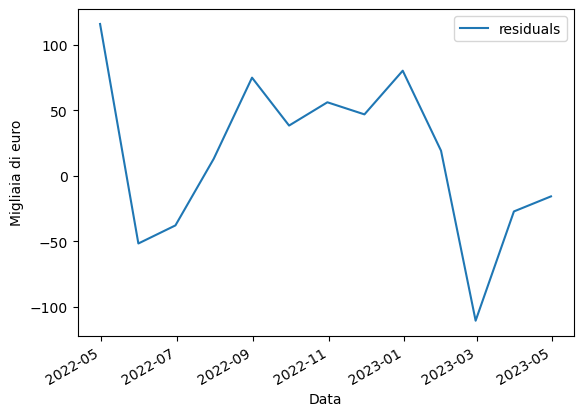

Esecuzione della pipeline Prophet per R000
Inizio della funzione prophet_pipeline
Esecuzione della funzione evaluate_prophet_model in parallelo su tutte le combinazioni di iperparametri
Ricerca della combinazione di iperparametri che minimizza l'RMSE normalizzato
Addestramento del modello Prophet sul train set utilizzando la migliore combinazione di iperparametri


12:47:32 - cmdstanpy - INFO - Chain [1] start processing
12:47:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet(changepoint_prior_scale=1.5, seasonality_prior_scale=0.01, holidays_prior_scale=0.001, seasonality_mode=multiplicative) - RMSE normalizzato: 0.21150083880686676


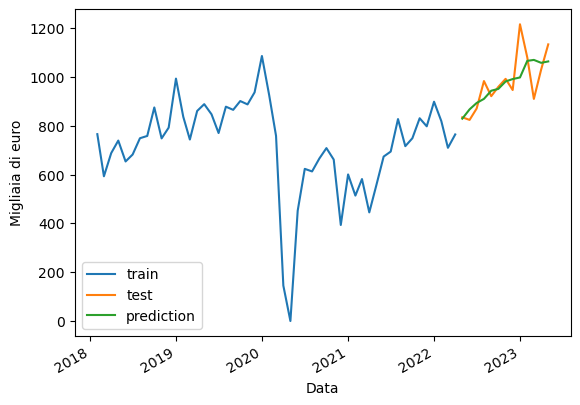

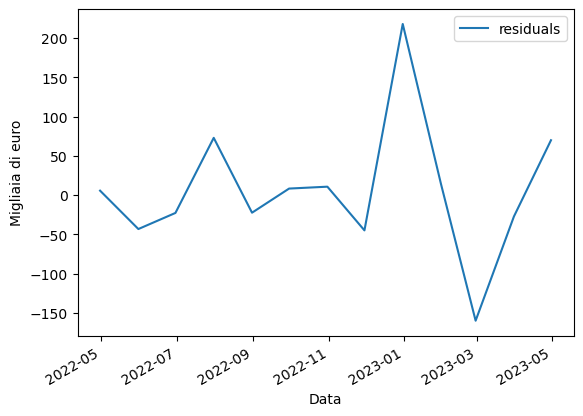

Fine della funzione prophet_pipeline
Esecuzione della pipeline SARIMAX per R001
SARIMAX(7, 2, 5)x(0, 0, 1, 12) - RMSE normalizzato: 0.266835606193544


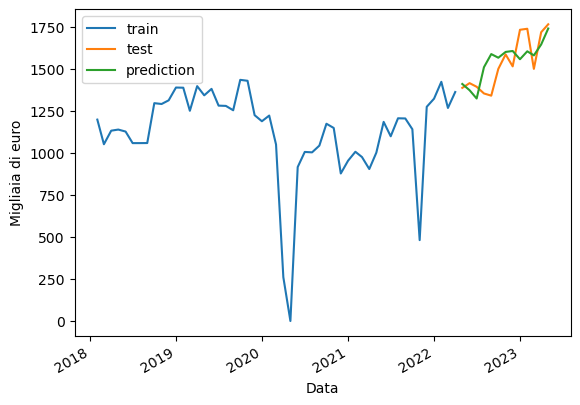

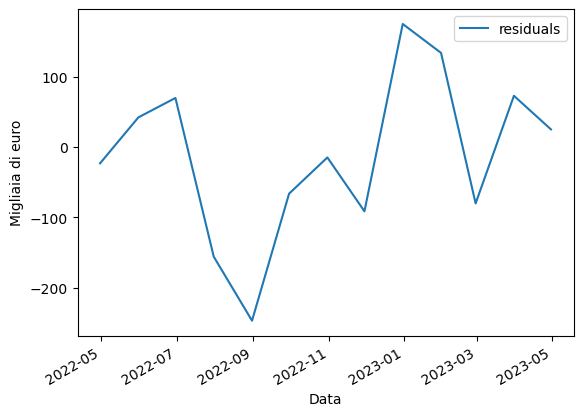

Esecuzione della pipeline Prophet per R001
Inizio della funzione prophet_pipeline
Esecuzione della funzione evaluate_prophet_model in parallelo su tutte le combinazioni di iperparametri


12:52:30 - cmdstanpy - INFO - Chain [1] start processing


Ricerca della combinazione di iperparametri che minimizza l'RMSE normalizzato
Addestramento del modello Prophet sul train set utilizzando la migliore combinazione di iperparametri


12:52:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet(changepoint_prior_scale=8.3, seasonality_prior_scale=0.01, holidays_prior_scale=0.001, seasonality_mode=multiplicative) - RMSE normalizzato: 0.26600632858013673


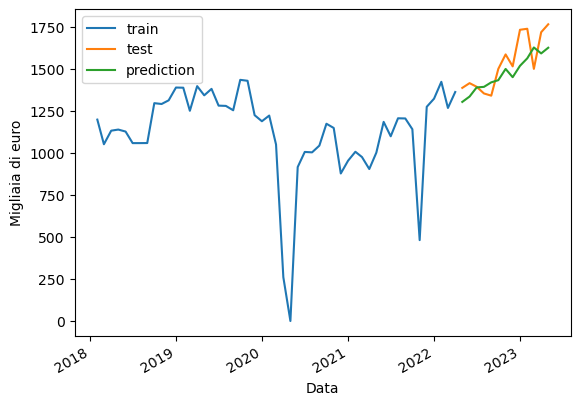

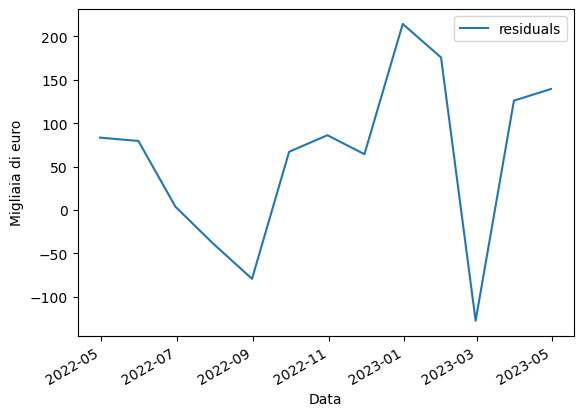

Fine della funzione prophet_pipeline
Esecuzione della pipeline SARIMAX per R002
SARIMAX(5, 2, 2)x(1, 0, 0, 12) - RMSE normalizzato: 0.18609403436203298


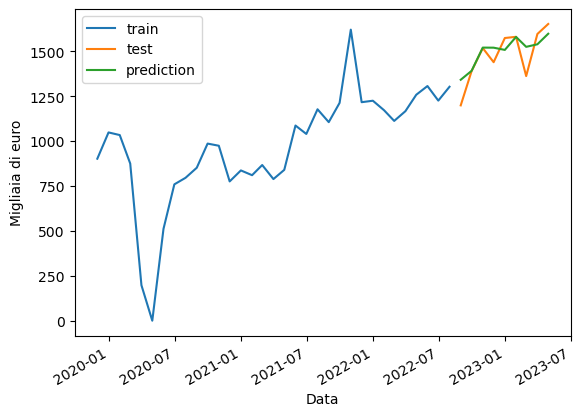

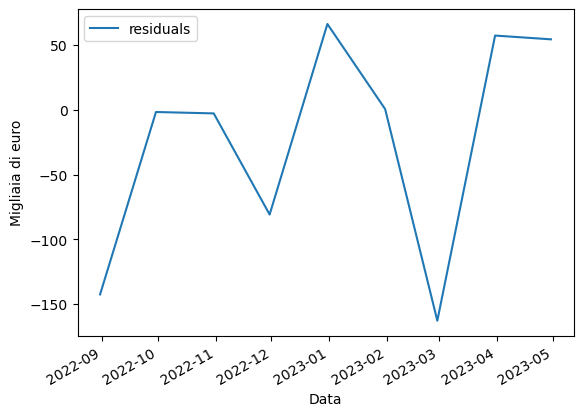

Esecuzione della pipeline Prophet per R002
Inizio della funzione prophet_pipeline
Esecuzione della funzione evaluate_prophet_model in parallelo su tutte le combinazioni di iperparametri


13:53:46 - cmdstanpy - INFO - Chain [1] start processing


Ricerca della combinazione di iperparametri che minimizza l'RMSE normalizzato
Addestramento del modello Prophet sul train set utilizzando la migliore combinazione di iperparametri


13:53:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet(changepoint_prior_scale=1.7, seasonality_prior_scale=0.01, holidays_prior_scale=0.01, seasonality_mode=additive) - RMSE normalizzato: 0.2189860476452057


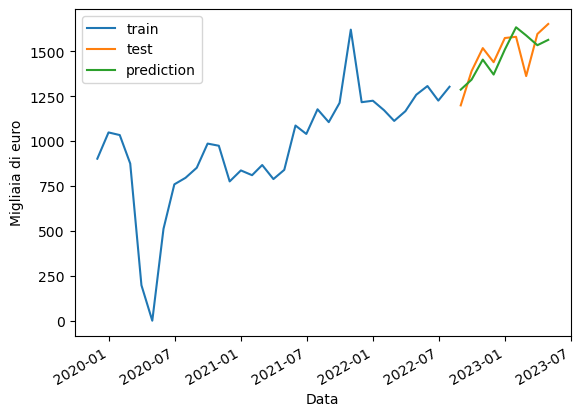

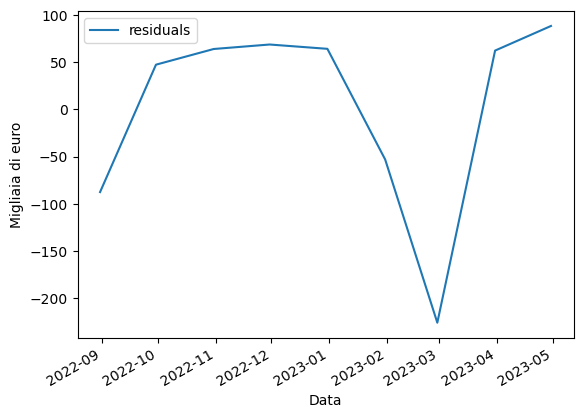

Fine della funzione prophet_pipeline
Esecuzione della pipeline SARIMAX per R003
SARIMAX(0, 2, 4)x(0, 1, 2, 12) - RMSE normalizzato: 0.13002208972162105


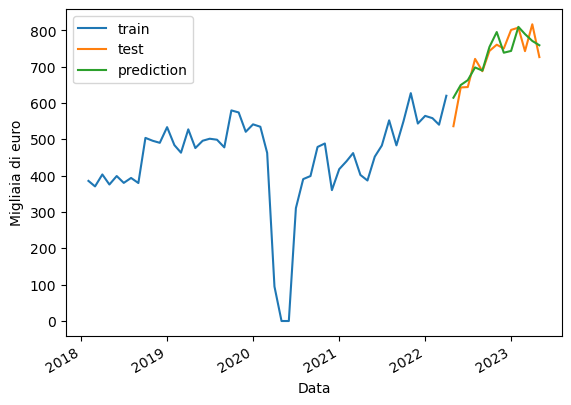

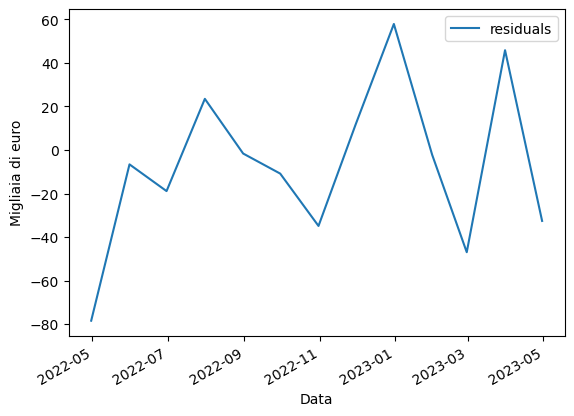

Esecuzione della pipeline Prophet per R003
Inizio della funzione prophet_pipeline
Esecuzione della funzione evaluate_prophet_model in parallelo su tutte le combinazioni di iperparametri


13:58:30 - cmdstanpy - INFO - Chain [1] start processing


Ricerca della combinazione di iperparametri che minimizza l'RMSE normalizzato
Addestramento del modello Prophet sul train set utilizzando la migliore combinazione di iperparametri


13:58:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet(changepoint_prior_scale=3.0, seasonality_prior_scale=0.1, holidays_prior_scale=0.001, seasonality_mode=additive) - RMSE normalizzato: 0.1348196720727333


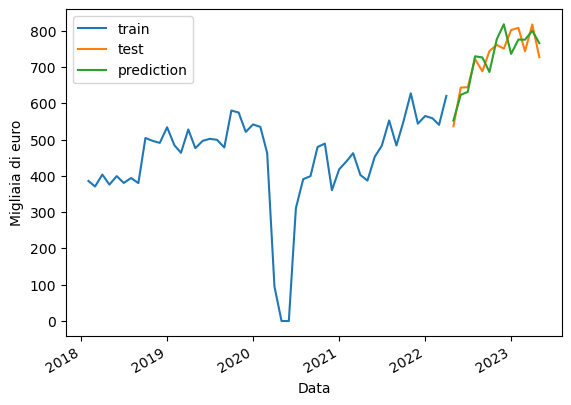

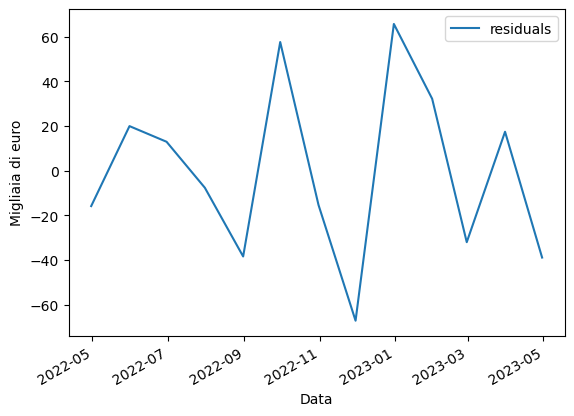

Fine della funzione prophet_pipeline
Esecuzione della pipeline SARIMAX per R004
SARIMAX(1, 2, 1)x(1, 0, 1, 12) - RMSE normalizzato: 0.26091271116758863


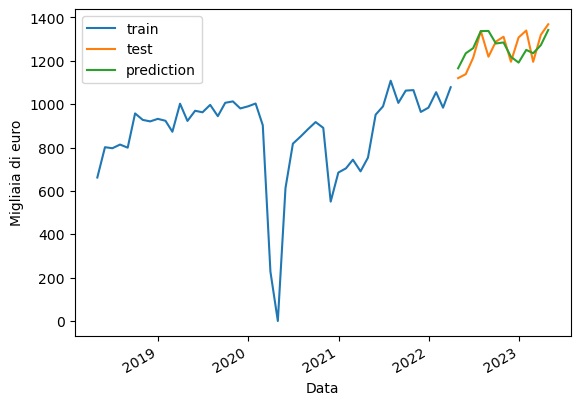

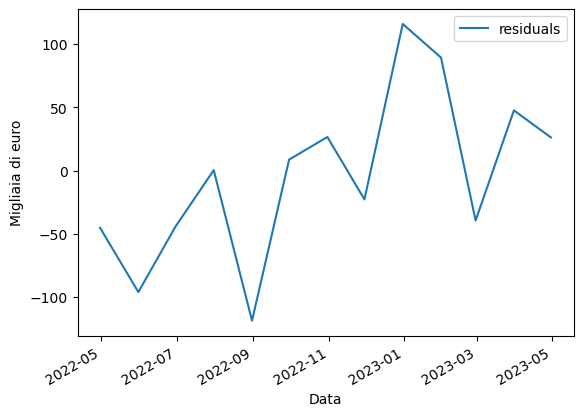

Esecuzione della pipeline Prophet per R004
Inizio della funzione prophet_pipeline
Esecuzione della funzione evaluate_prophet_model in parallelo su tutte le combinazioni di iperparametri


14:03:25 - cmdstanpy - INFO - Chain [1] start processing
14:03:25 - cmdstanpy - INFO - Chain [1] done processing


Ricerca della combinazione di iperparametri che minimizza l'RMSE normalizzato
Addestramento del modello Prophet sul train set utilizzando la migliore combinazione di iperparametri
Prophet(changepoint_prior_scale=3.8, seasonality_prior_scale=0.01, holidays_prior_scale=1, seasonality_mode=multiplicative) - RMSE normalizzato: 0.2734147724592152


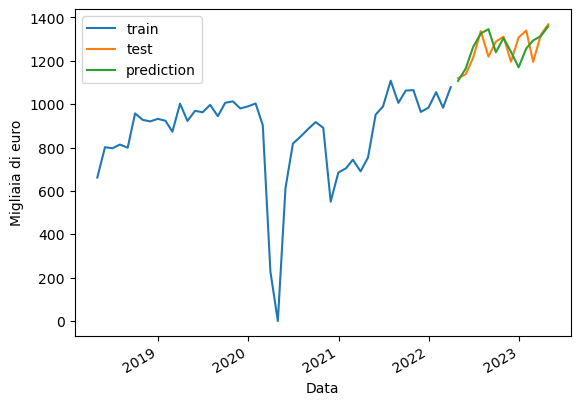

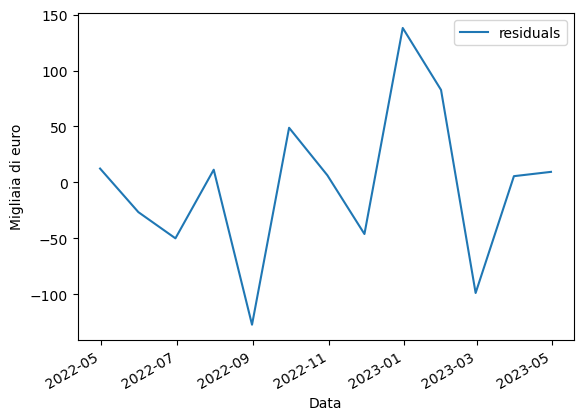

Fine della funzione prophet_pipeline
Esecuzione della pipeline SARIMAX per R005
SARIMAX(7, 2, 6)x(1, 0, 0, 12) - RMSE normalizzato: 0.205963517950743


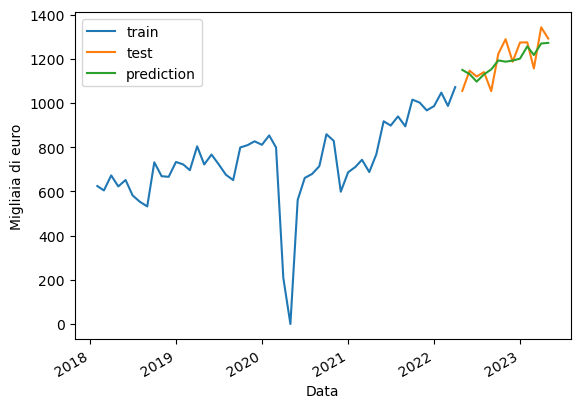

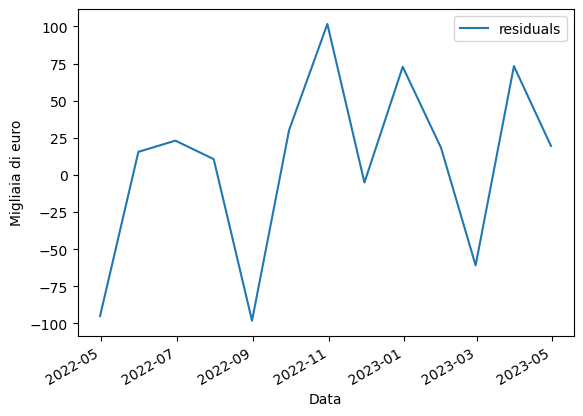

Esecuzione della pipeline Prophet per R005
Inizio della funzione prophet_pipeline
Esecuzione della funzione evaluate_prophet_model in parallelo su tutte le combinazioni di iperparametri


14:07:52 - cmdstanpy - INFO - Chain [1] start processing


Ricerca della combinazione di iperparametri che minimizza l'RMSE normalizzato
Addestramento del modello Prophet sul train set utilizzando la migliore combinazione di iperparametri


14:07:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet(changepoint_prior_scale=0.6, seasonality_prior_scale=0.01, holidays_prior_scale=0.001, seasonality_mode=multiplicative) - RMSE normalizzato: 0.21594901083897666


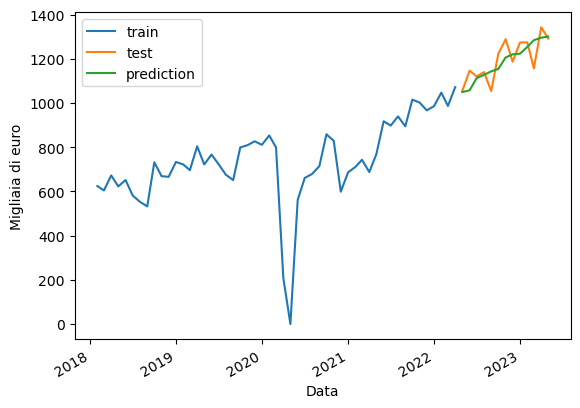

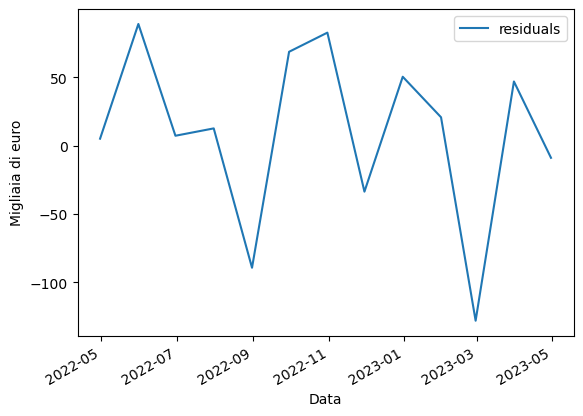

Fine della funzione prophet_pipeline


In [2]:
# Esegui le due pipeline per tutti i dataframe
for i in range(6):
    ristorante = f'R{i:03d}'
    df = globals()[f'ristorante_{ristorante}_mensile']
    
    print(f'Esecuzione della pipeline SARIMAX per {ristorante}')
    p,d,q,P,D,Q = sarimax_pipeline(df)
    
    print(f'Esecuzione della pipeline Prophet per {ristorante}')
    changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale, seasonality_mode, = prophet_pipeline(df)

14:07:53 - cmdstanpy - INFO - Chain [1] start processing
14:07:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet(changepoint_prior_scale=0.6, seasonality_prior_scale=0.01, holidays_prior_scale=0.001, seasonality_mode=multiplicative)


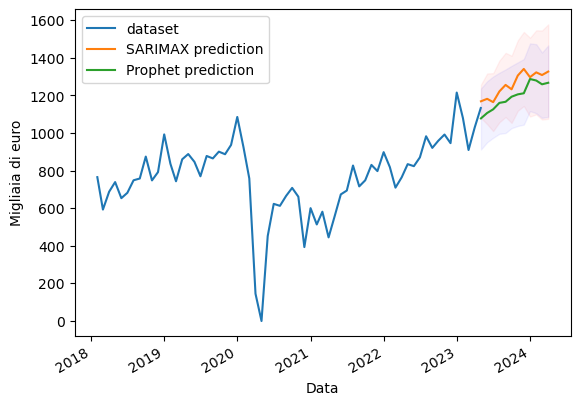

14:07:54 - cmdstanpy - INFO - Chain [1] start processing
14:07:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet(changepoint_prior_scale=0.6, seasonality_prior_scale=0.01, holidays_prior_scale=0.001, seasonality_mode=multiplicative)


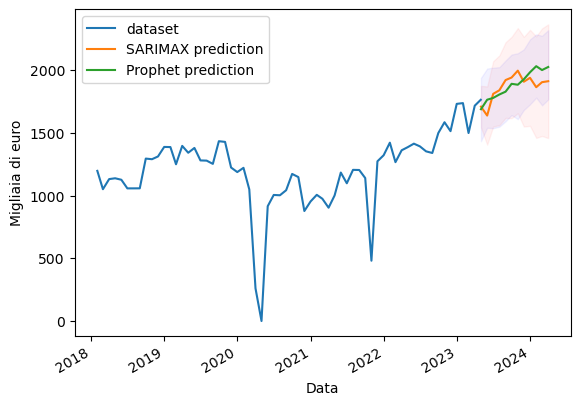

14:07:55 - cmdstanpy - INFO - Chain [1] start processing
14:07:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet(changepoint_prior_scale=0.6, seasonality_prior_scale=0.01, holidays_prior_scale=0.001, seasonality_mode=multiplicative)


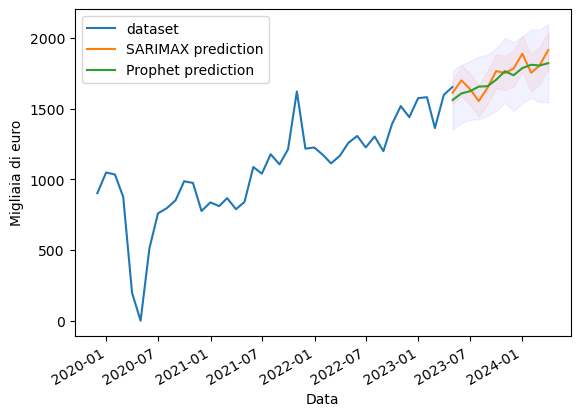

14:07:56 - cmdstanpy - INFO - Chain [1] start processing
14:07:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet(changepoint_prior_scale=0.6, seasonality_prior_scale=0.01, holidays_prior_scale=0.001, seasonality_mode=multiplicative)


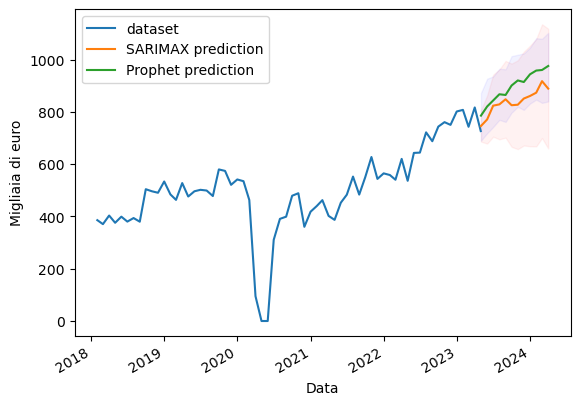

14:07:57 - cmdstanpy - INFO - Chain [1] start processing
14:07:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet(changepoint_prior_scale=0.6, seasonality_prior_scale=0.01, holidays_prior_scale=0.001, seasonality_mode=multiplicative)


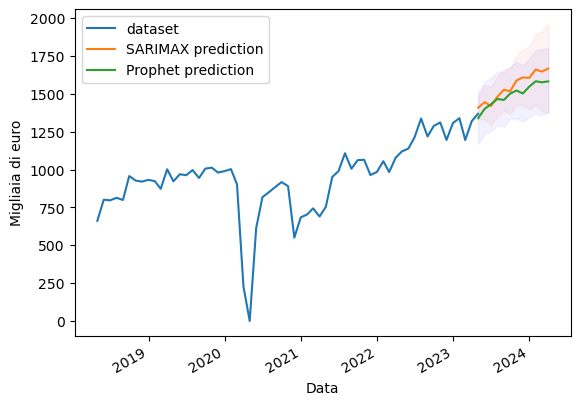

14:07:59 - cmdstanpy - INFO - Chain [1] start processing
14:07:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet(changepoint_prior_scale=0.6, seasonality_prior_scale=0.01, holidays_prior_scale=0.001, seasonality_mode=multiplicative)


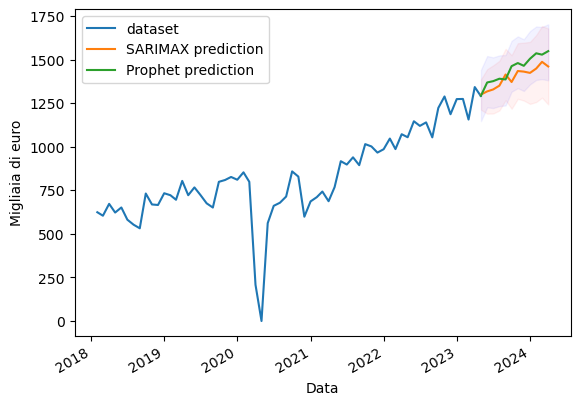

In [3]:
# Riaddestra i modelli su tutta la lunghezza del set di dati e fai una previsione di un anno nel futuro
for i in range(6):
    ristorante = f'R{i:03d}'
    df = globals()[f'ristorante_{ristorante}_mensile']
    
    # Riaddestra il modello SARIMAX
    exog = df[['partite giornaliere', 'precipitazioni(mm)', 'temperatura(°C)']]
    model_sarimax = SARIMAX(df[ristorante], exog=exog, order=(p,d,q), seasonal_order=(P,D,Q,12)).fit()
    
    # Fai una previsione di un anno nel futuro con il modello SARIMAX
    last_date = df.index[-1]
    start_date = last_date + pd.DateOffset(months=1) - pd.DateOffset(days=last_date.day - 1)
    future_dates = pd.date_range(start=start_date, periods=12, freq='MS')

    future_exog = pd.DataFrame(index=future_dates)
    future_exog['partite giornaliere'] = 0
    future_exog['precipitazioni(mm)'] = df['precipitazioni(mm)'].mean()
    future_exog['temperatura(°C)'] = df['temperatura(°C)'].mean()
    
     # Calcola la previsione e gli intervalli di confidenza del modello SARIMAX
    prediction_sarimax = model_sarimax.get_forecast(steps=12, exog=future_exog, alpha=0.5)
    prediction_sarimax_mean = prediction_sarimax.predicted_mean
    prediction_sarimax_conf_int = prediction_sarimax.conf_int(alpha=0.5)
    
     # Prepara i dati per Prophet
    df_prophet = df.reset_index().rename(columns={'data': 'ds', ristorante: 'y'})
    
     # Riaddestra il modello Prophet
    model_prophet = Prophet(changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale, holidays_prior_scale=holidays_prior_scale, seasonality_mode=seasonality_mode)
    model_prophet.add_regressor('partite giornaliere')
    model_prophet.add_regressor('precipitazioni(mm)')
    model_prophet.add_regressor('temperatura(°C)')
    model_prophet.fit(df_prophet)
    
     # Stampa gli iperparametri usati dal modello Prophet
    print(f'Prophet(changepoint_prior_scale={changepoint_prior_scale}, seasonality_prior_scale={seasonality_prior_scale}, holidays_prior_scale={holidays_prior_scale}, seasonality_mode={seasonality_mode})')
    
     # Fai una previsione di un anno nel futuro con il modello Prophet
    future = model_prophet.make_future_dataframe(periods=12, freq='MS')
    future['partite giornaliere'] = 0
    future['precipitazioni(mm)'] = df['precipitazioni(mm)'].mean()
    future['temperatura(°C)'] = df['temperatura(°C)'].mean()
    
    forecast = model_prophet.predict(future)
    
     # Calcola la previsione e gli intervalli di confidenza del modello Prophet
    prediction_prophet_mean = forecast.iloc[-12:]['yhat']
    prediction_prophet_conf_int_lower = forecast.iloc[-12:]['yhat_lower']
    prediction_prophet_conf_int_upper = forecast.iloc[-12:]['yhat_upper']
     
     # Stampa il grafico con il dataset, la predizione di Prophet e quella di SARIMAX
    fig, ax = plt.subplots()
     
    ax.plot(df.index, df[ristorante]/1000.0, label='dataset')
     
    ax.plot(future_dates, prediction_sarimax_mean/1000.0, label='SARIMAX prediction')
     
     # Aggiungi gli intervalli di confidenza della predizione del modello SARIMAX
    ax.fill_between(future_dates,
                    prediction_sarimax_conf_int.iloc[:, 0]/1000.0,
                    prediction_sarimax_conf_int.iloc[:, 1]/1000.0,
                    color='r', alpha=0.05)
     
    ax.plot(future_dates, prediction_prophet_mean/1000.0, label='Prophet prediction')
     
     # Aggiungi gli intervalli di confidenza della predizione del modello Prophet
    ax.fill_between(future_dates,
                    prediction_prophet_conf_int_lower/1000.0,
                    prediction_prophet_conf_int_upper/1000.0,
                    color='b', alpha=0.05)
    
    ax.legend()
    fig.autofmt_xdate()
     # Aggiungi le legende degli assi
    ax.set_xlabel('Data')
    ax.set_ylabel('Migliaia di euro')
    plt.show()


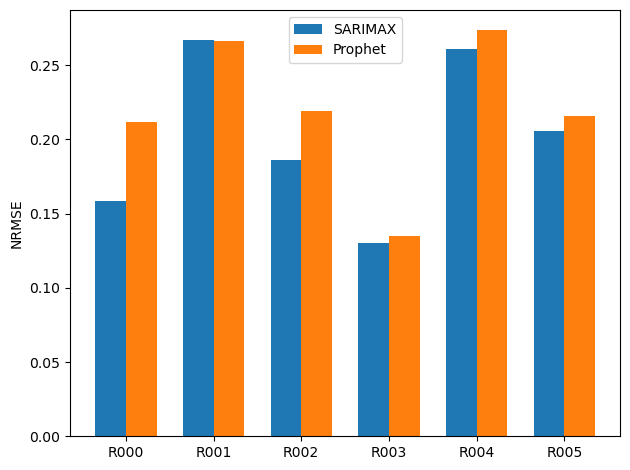

In [4]:
#Crea istogramma NMRSE Prophet
ristoranti = ['R000', 'R001', 'R002', 'R003','R004','R005']
nrmse_sarimax = [0.1587, 0.2668, 0.1860, 0.1300,0.2609,0.2059]
nrmse_prophet = [0.2115, 0.2660, 0.2189, 0.1348,0.2734,0.2159]

bar_width = 0.35
x = np.arange(len(ristoranti))

fig, ax = plt.subplots()
rects1 = ax.bar(x - bar_width/2, nrmse_sarimax, bar_width, label='SARIMAX')
rects2 = ax.bar(x + bar_width/2, nrmse_prophet, bar_width, label='Prophet')

ax.set_ylabel('NRMSE')
ax.set_xticks(x)
ax.set_xticklabels(ristoranti)
ax.legend()

fig.tight_layout()
plt.show()


In [5]:
from tabulate import tabulate

# Riaddestra i modelli su tutta la lunghezza del set di dati e fai una previsione di un anno nel futuro
for i in range(6):
    ristorante = f'R{i:03d}'
    df = globals()[f'ristorante_{ristorante}_mensile']
    
    # Verifica se ci sono valori NaN nelle colonne dei regressori
    if df[['partite giornaliere', 'precipitazioni(mm)', 'temperatura(°C)']].isna().any().any():
        print(f"Attenzione: ci sono valori NaN nelle colonne dei regressori per il ristorante {ristorante}. Impossibile addestrare i modelli.")
        continue
    
    # Riaddestra il modello SARIMAX
    exog = df[['partite giornaliere', 'precipitazioni(mm)', 'temperatura(°C)']]
    model_sarimax = SARIMAX(df[ristorante], exog=exog, order=(p,d,q), seasonal_order=(P,D,Q,12)).fit()
    
    # Fai una previsione di un anno nel futuro con il modello SARIMAX
    last_date = df.index[-1]
    start_date = last_date + pd.DateOffset(months=1) - pd.DateOffset(days=last_date.day - 1)
    future_dates = pd.date_range(start=start_date, periods=12, freq='MS')

    future_exog = pd.DataFrame(index=future_dates)
    future_exog['partite giornaliere'] = 0
    future_exog['precipitazioni(mm)'] = df['precipitazioni(mm)'].mean()
    future_exog['temperatura(°C)'] = df['temperatura(°C)'].mean()
    
    # Calcola la previsione del modello SARIMAX
    prediction_sarimax = model_sarimax.get_forecast(steps=12, exog=future_exog)
    prediction_sarimax_mean = prediction_sarimax.predicted_mean
    
    # Prepara i dati per Prophet
    df_prophet = df.reset_index().rename(columns={'data': 'ds', ristorante: 'y'})
    
    # Riaddestra il modello Prophet
    model_prophet = Prophet(changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale, holidays_prior_scale=holidays_prior_scale, seasonality_mode=seasonality_mode)
    model_prophet.add_regressor('partite giornaliere')
    model_prophet.add_regressor('precipitazioni(mm)')
    model_prophet.add_regressor('temperatura(°C)')
    model_prophet.fit(df_prophet)
    
    # Fai una previsione di un anno nel futuro con il modello Prophet
    future = model_prophet.make_future_dataframe(periods=12, freq='MS')
    future['partite giornaliere'] = 0
    future['precipitazioni(mm)'] = df['precipitazioni(mm)'].mean()
    future['temperatura(°C)'] = df['temperatura(°C)'].mean()
    
    forecast = model_prophet.predict(future)
    
     # Calcola la previsione del modello Prophet
    prediction_prophet_mean = forecast.iloc[-12:]['yhat']
    
     # Crea una tabella LaTeX con i dati mensili della previsione di Prophet e di SARIMAX espressi in migliaia di euro e arrotondati all'intero più vicino
    table_data = [['Mese', 'Prophet (migliaia di euro)', 'SARIMAX (migliaia di euro)']]
    for j in range(12):
        month = future_dates[j].strftime('%Y-%m')
        prophet_prediction = round(prediction_prophet_mean.iloc[j] / 1000)
        sarimax_prediction = round(prediction_sarimax_mean.iloc[j] / 1000)
        table_data.append([month, prophet_prediction, sarimax_prediction])
    table_string = tabulate(table_data, headers='firstrow', tablefmt='latex')
    print(f'Tabella LaTeX per il ristorante {ristorante}:')
    print(table_string)


14:08:00 - cmdstanpy - INFO - Chain [1] start processing
14:08:00 - cmdstanpy - INFO - Chain [1] done processing


Tabella LaTeX per il ristorante R000:
\begin{tabular}{lrr}
\hline
 Mese    &   Prophet (migliaia di euro) &   SARIMAX (migliaia di euro) \\
\hline
 2023-05 &                         1078 &                         1169 \\
 2023-06 &                         1107 &                         1182 \\
 2023-07 &                         1126 &                         1164 \\
 2023-08 &                         1160 &                         1221 \\
 2023-09 &                         1166 &                         1256 \\
 2023-10 &                         1193 &                         1233 \\
 2023-11 &                         1206 &                         1306 \\
 2023-12 &                         1212 &                         1341 \\
 2024-01 &                         1288 &                         1297 \\
 2024-02 &                         1280 &                         1323 \\
 2024-03 &                         1259 &                         1309 \\
 2024-04 &                         1268

14:08:01 - cmdstanpy - INFO - Chain [1] start processing
14:08:01 - cmdstanpy - INFO - Chain [1] done processing


Tabella LaTeX per il ristorante R001:
\begin{tabular}{lrr}
\hline
 Mese    &   Prophet (migliaia di euro) &   SARIMAX (migliaia di euro) \\
\hline
 2023-05 &                         1689 &                         1710 \\
 2023-06 &                         1765 &                         1638 \\
 2023-07 &                         1779 &                         1811 \\
 2023-08 &                         1806 &                         1840 \\
 2023-09 &                         1829 &                         1921 \\
 2023-10 &                         1891 &                         1942 \\
 2023-11 &                         1884 &                         1996 \\
 2023-12 &                         1927 &                         1908 \\
 2024-01 &                         1983 &                         1939 \\
 2024-02 &                         2032 &                         1864 \\
 2024-03 &                         2001 &                         1904 \\
 2024-04 &                         2026

14:08:01 - cmdstanpy - INFO - Chain [1] start processing
14:08:02 - cmdstanpy - INFO - Chain [1] done processing


Tabella LaTeX per il ristorante R002:
\begin{tabular}{lrr}
\hline
 Mese    &   Prophet (migliaia di euro) &   SARIMAX (migliaia di euro) \\
\hline
 2023-05 &                         1560 &                         1611 \\
 2023-06 &                         1607 &                         1699 \\
 2023-07 &                         1623 &                         1638 \\
 2023-08 &                         1655 &                         1553 \\
 2023-09 &                         1658 &                         1648 \\
 2023-10 &                         1703 &                         1765 \\
 2023-11 &                         1764 &                         1751 \\
 2023-12 &                         1735 &                         1782 \\
 2024-01 &                         1786 &                         1888 \\
 2024-02 &                         1810 &                         1753 \\
 2024-03 &                         1804 &                         1803 \\
 2024-04 &                         1821

14:08:03 - cmdstanpy - INFO - Chain [1] start processing
14:08:03 - cmdstanpy - INFO - Chain [1] done processing


Tabella LaTeX per il ristorante R003:
\begin{tabular}{lrr}
\hline
 Mese    &   Prophet (migliaia di euro) &   SARIMAX (migliaia di euro) \\
\hline
 2023-05 &                          786 &                          746 \\
 2023-06 &                          821 &                          771 \\
 2023-07 &                          844 &                          824 \\
 2023-08 &                          867 &                          829 \\
 2023-09 &                          865 &                          848 \\
 2023-10 &                          901 &                          826 \\
 2023-11 &                          920 &                          827 \\
 2023-12 &                          914 &                          851 \\
 2024-01 &                          944 &                          861 \\
 2024-02 &                          958 &                          873 \\
 2024-03 &                          960 &                          918 \\
 2024-04 &                          976

14:08:03 - cmdstanpy - INFO - Chain [1] start processing
14:08:04 - cmdstanpy - INFO - Chain [1] done processing


Tabella LaTeX per il ristorante R004:
\begin{tabular}{lrr}
\hline
 Mese    &   Prophet (migliaia di euro) &   SARIMAX (migliaia di euro) \\
\hline
 2023-05 &                         1340 &                         1409 \\
 2023-06 &                         1402 &                         1446 \\
 2023-07 &                         1431 &                         1420 \\
 2023-08 &                         1467 &                         1481 \\
 2023-09 &                         1460 &                         1527 \\
 2023-10 &                         1502 &                         1517 \\
 2023-11 &                         1523 &                         1589 \\
 2023-12 &                         1503 &                         1609 \\
 2024-01 &                         1548 &                         1606 \\
 2024-02 &                         1584 &                         1661 \\
 2024-03 &                         1577 &                         1647 \\
 2024-04 &                         1583

14:08:05 - cmdstanpy - INFO - Chain [1] start processing
14:08:05 - cmdstanpy - INFO - Chain [1] done processing


Tabella LaTeX per il ristorante R005:
\begin{tabular}{lrr}
\hline
 Mese    &   Prophet (migliaia di euro) &   SARIMAX (migliaia di euro) \\
\hline
 2023-05 &                         1293 &                         1300 \\
 2023-06 &                         1369 &                         1318 \\
 2023-07 &                         1376 &                         1329 \\
 2023-08 &                         1390 &                         1351 \\
 2023-09 &                         1386 &                         1415 \\
 2023-10 &                         1463 &                         1372 \\
 2023-11 &                         1480 &                         1435 \\
 2023-12 &                         1465 &                         1431 \\
 2024-01 &                         1505 &                         1424 \\
 2024-02 &                         1536 &                         1449 \\
 2024-03 &                         1529 &                         1487 \\
 2024-04 &                         1549